In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import seaborn as sns
import matplotlib.pyplot as plt
# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

# optuna
import optuna
from optuna.samplers import TPESampler

#sklearn
from sklearn.ensemble import GradientBoostingClassifier,StackingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import AdaBoostClassifier
from sklearn.pipeline import Pipeline
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import SimpleImputer
from sklearn.decomposition import PCA
from sklearn.preprocessing import PolynomialFeatures,StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import KFold
from sklearn.metrics import roc_curve, auc

#xgboost
from xgboost import XGBClassifier

#catboost
from catboost import CatBoostClassifier

#lightboost
import lightgbm as lgb



from string import ascii_letters
import os
import pickle
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

#### Helper Functions

In [ ]:
plt.style.use("seaborn-whitegrid")
plt.rc("figure", autolayout=True)
plt.rc(
    "axes",
    labelweight="bold",
    labelsize="large",
    titleweight="bold",
    titlesize=14,
    titlepad=10,
)


def plot_variance(pca, width=8, dpi=100):
    # Create figure
    fig, axs = plt.subplots(1, 2)
    n = pca.n_components_
    grid = np.arange(1, n + 1)
    # Explained variance
    evr = pca.explained_variance_ratio_
    axs[0].bar(grid, evr)
    axs[0].set(
        xlabel="Component", title="% Explained Variance", ylim=(0.0, 1.0)
    )
    # Cumulative Variance
    cv = np.cumsum(evr)
    axs[1].plot(np.r_[0, grid], np.r_[0, cv], "o-")
    axs[1].set(
        xlabel="Component", title="% Cumulative Variance", ylim=(0.0, 1.0)
    )
    # Set up figure
    fig.set(figwidth=8, dpi=100)
    return axs

_________________________________________________________________________________________________

#### LightGBM GPU Support

In [ ]:
!rm -r /opt/conda/lib/python3.6/site-packages/lightgbm
!git clone --recursive https://github.com/Microsoft/LightGBM

In [ ]:
!apt-get install -y -qq libboost-all-dev

In [ ]:
%%bash
cd LightGBM
rm -r build
mkdir build
cd build
cmake -DUSE_GPU=1 -DOpenCL_LIBRARY=/usr/local/cuda/lib64/libOpenCL.so -DOpenCL_INCLUDE_DIR=/usr/local/cuda/include/ ..
make -j$(nproc)

In [ ]:
!cd LightGBM/python-package/;python3 setup.py install --precompile

In [ ]:
!mkdir -p /etc/OpenCL/vendors && echo "libnvidia-opencl.so.1" > /etc/OpenCL/vendors/nvidia.icd
!rm -r LightGBM

--------------------------------------------------------------------------------------------------------------------------

In [ ]:
train=pd.read_csv("../input/tabular-playground-series-sep-2021/train.csv")
test=pd.read_csv("../input/tabular-playground-series-sep-2021/test.csv")

In [ ]:
train.select_dtypes("float64").shape[1]==train.shape[1]-2

In [ ]:
sns.displot(train["claim"])

**<p> The dataset seems balanced which is a good thing :D </p>**

In [ ]:
from string import ascii_letters
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

sns.set_theme(style="white")



# Compute the correlation matrix
corr = train.corr()

# Generate a mask for the upper triangle
mask = np.triu(np.ones_like(corr, dtype=bool))

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(11, 9))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(230, 20, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.3, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})

**<p> No Multi-Collinearity at all which is a good thing </p>**

In [ ]:
train.corr()["claim"].map(lambda x:abs(x)).sort_values()

In [ ]:
train.isnull().sum()

# Using Mean Imputing for Strategies A,B,C

<img src="https://miro.medium.com/max/700/1*MiJ_HpTbZECYjjF1qepNNQ.png">

In [ ]:
X,y=train.drop(["id","claim"],1),train["claim"]
imputer = SimpleImputer(strategy='mean')
X=imputer.fit_transform(X)
X_test=imputer.transform(test.drop('id',1))

In [ ]:
X.shape

# Stack Net Architecture Used for A,B,C

<img src="http://rasbt.github.io/mlxtend/user_guide/classifier/StackingClassifier_files/stackingclassification_overview.png">

In [ ]:
def create_stack(**kwargs):
    '''
    Input:
        **Kwargs:Dict Consist of all the Main Learners that I want for the stack
    Output:
        Stack:Sklearn Classifier
    '''
    #meta learner
    LR=LogisticRegression()
    estimators = [(key,value) for key,value in kwargs.items()]
    Stack = StackingClassifier(estimators=estimators, final_estimator= LR, cv= 5, n_jobs= -1, passthrough = True,stack_method='predict_proba')
    return Stack

## A) Base Prediction(Simple Mean Imputing)

In [ ]:
#stack=create_stack(adaboost=AdaBoostClassifier(),xgb=XGBClassifier(tree_method='gpu_hist'),
            #lgbm=lgb.LGBMClassifier(objective="binary",device='gpu'))
#stack.fit(X,y)

In [ ]:
#predictions=stack.predict(X_test)

### Score on Leaderboard

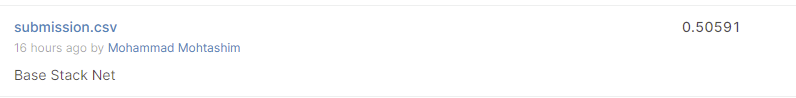

## B) Featuring Engineering(PCA+Simple Mean Imputing+StandardScaler)

In [ ]:
pca=PCA(n_components=5)
pca.fit(X)

In [ ]:
#stack=create_stack(adaboost=AdaBoostClassifier(),xgb=XGBClassifier(tree_method='gpu_hist'),
            #lgbm=lgb.LGBMClassifier(objective="binary",device='gpu'))

In [ ]:
#pipeline=Pipeline([('StandardScaler',StandardScaler()),
      #   ('PCA',PCA(n_components=5)),('stack',stack)])

In [ ]:
plot_variance(pca, width=8, dpi=100)

In [ ]:
#pipeline.fit(X,y)

In [ ]:
#predictions=pipeline.predict_proba(X_test)

In [ ]:
#sns.distplot(predictions[:,1])

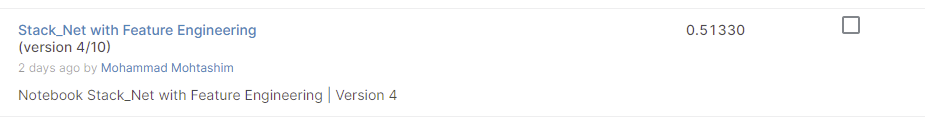

## C) Feature Engineering(Adding PCA Features+Simple Mean Imputing)

In [ ]:
X_pca=pca.transform(X)

In [ ]:
for i in range(X_pca.shape[1]):
    X=np.concatenate((X,X_pca[:,i].reshape(-1,1)),axis=1)

In [ ]:
#stack=create_stack(adaboost=AdaBoostClassifier(),xgb=XGBClassifier(tree_method='gpu_hist'),lgbm=lgb.LGBMClassifier(objective="binary",device='gpu'))
#stack.fit(X,y)

In [ ]:
X_pca_test=pca.transform(X_test)

In [ ]:
for i in range(X_pca_test.shape[1]):
    X_test=np.concatenate((X_test,X_pca_test[:,i].reshape(-1,1)),axis=1)

In [ ]:
#predictions=stack.predict_proba(X_test)

In [ ]:
del X_pca_test
del X_pca

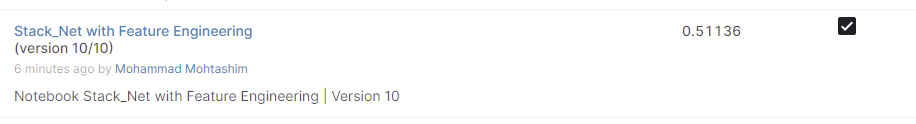

> ## Hyper-Parameter Tuning(Optuna) for Xgboost and LightGBM given a Strategy
        Please Note:
        1- Removing Adaboost because tunning it takes alot of running time
        2- Going to use this for Strategy C and D

#### 1- Xgboost

In [ ]:
def objective_xgboost(trial):

    param_grid = {'objective': 'binary:logistic',
              'use_label_encoder': False,
              'n_estimators': trial.suggest_int('n_estimators', 1000, 5000),
              'learning_rate': trial.suggest_discrete_uniform('learning_rate',0.01,0.1,0.01),
              'subsample': trial.suggest_discrete_uniform('subsample', 0.3, 1.0, 0.1),
              'colsample_bytree': trial.suggest_uniform('colsample_bytree',0.1,1.0),
              'max_depth': trial.suggest_int('max_depth', 3, 20),
              'booster': 'gbtree',
              'gamma': trial.suggest_uniform('gamma',1.0,10.0),
              'reg_alpha': trial.suggest_int('reg_alpha',50,100),
              'reg_lambda': trial.suggest_int('reg_lambda',50,100),
              'random_state': 42,
                 }


    xgb_model = XGBClassifier(**param_grid, tree_method='gpu_hist', predictor='gpu_predictor')

    xgb_model.fit(x_train, y_train, verbose=False)
    y_pred = xgb_model.predict_proba(x_val)[:, 1]
    return roc_auc_score(y_val, y_pred)

In [ ]:
def xgboost_optimize():
    train_time = 1 * 30 * 60 # h * m * s
    study = optuna.create_study(direction='maximize', sampler=TPESampler(), study_name='XGBClassifier')
    study.optimize(objective_xgboost, timeout=train_time)

    print('Number of finished trials: ', len(study.trials))
    print('Best trial:')
    trial = study.best_trial

    print('\tValue: {}'.format(trial.value))
    print('\tParams: ')
    for key, value in trial.params.items():
        print('\t\t{}: {}'.format(key, value))

#### 2- LightGBM

In [ ]:
def objective_lightgbm(trial):
    param = {
            'objective': 'binary',
            'metric': 'binary_logloss',
            'lambda_l1': trial.suggest_loguniform('lambda_l1', 1e-8, 10.0),
            'lambda_l2': trial.suggest_loguniform('lambda_l2', 1e-8, 10.0),
            'num_leaves': trial.suggest_int('num_leaves', 2, 256),
            'feature_fraction': trial.suggest_uniform('feature_fraction', 0.4, 1.0),
            'bagging_fraction': trial.suggest_uniform('bagging_fraction', 0.4, 1.0),
            'bagging_freq': trial.suggest_int('bagging_freq', 1, 7),
            'min_child_samples': trial.suggest_int('min_child_samples', 5, 100),
        }


    lgb_model = lgb.LGBMClassifier(**param,device='gpu')

    lgb_model.fit(x_train, y_train, verbose=False)
    y_pred = lgb_model.predict_proba(x_val)[:, 1]
    return roc_auc_score(y_val, y_pred)

In [ ]:
def light_gbm_optimize():
    train_time = 1 * 30 * 60 # h * m * s
    study = optuna.create_study(direction='maximize', sampler=TPESampler(), study_name='LightGBMClassifier')
    study.optimize(objective_lightgbm, timeout=train_time)

    print('Number of finished trials: ', len(study.trials))
    print('Best trial:')
    trial = study.best_trial

    print('\tValue: {}'.format(trial.value))
    print('\tParams: ')
    for key, value in trial.params.items():
        print('\t\t{}: {}'.format(key, value))

In [ ]:
#For C Strategy
parms_xg={'n_estimators': 2293,'learning_rate': 0.04,'subsample': 0.6000000000000001,'colsample_bytree': 0.10086730985728953,
'max_depth': 19,'gamma': 5.050049288179512,'reg_alpha': 90,'reg_lambda': 50}

parms_lgbm={'lambda_l1': 0.7625376202750715,
'lambda_l2': 2.917592113412615e-05,
'num_leaves': 172,
'feature_fraction': 0.4767313692164907,
'bagging_fraction': 0.9929830736818223,
'bagging_freq': 7,
'min_child_samples': 74}

#stack=create_stack(xgb=XGBClassifier(**parms_xg,tree_method='gpu_hist'),
                  # lgbm=lgb.LGBMClassifier(**parms_lgbm,device='gpu'))

In [ ]:
#stack.fit(X,y)

In [ ]:
#predictions=stack.predict_proba(X_test)

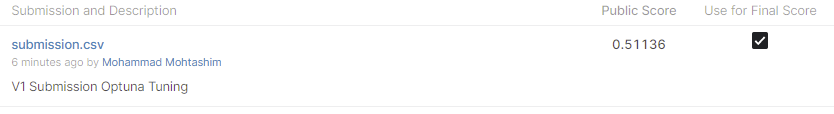

<p> Stack is Not Working; Lets Try Individual Models and some other kind of feature engineering </p>



## D) Individual Boosting Models-(StandardScaling+Simple Mean Imputation+Statistical Feature Engineering)

**<p> Took the best params for Catboost and K_fold training Strategy from [tps-09-single-catboostclassifier](https://www.kaggle.com/mlanhenke/tps-09-single-catboostclassifier)</p>**

In [ ]:
# feature Engineering
def get_stats_per_row(data):
    data['mv_row'] = data.isna().sum(axis=1)
    data['min_row'] = data.min(axis=1)
    data['std_row'] = data.std(axis=1)
    return data

In [ ]:
X,y=train.drop(["id","claim"],1),train["claim"]
X_test=test.drop('id',1)

In [ ]:
X = get_stats_per_row(X)
X_test = get_stats_per_row(X_test)

In [ ]:
pipeline = Pipeline([
    ('impute', SimpleImputer(strategy='mean')),
    ('scale', StandardScaler())
])

X = pd.DataFrame(columns=X.columns, data=pipeline.fit_transform(X))
X_test = pd.DataFrame(columns=X_test.columns, data=pipeline.transform(X_test))

In [ ]:
del train

### K-Fold Training Stratgy

In [ ]:
def k_fold(model_instance,param=None):
    kf = KFold(n_splits=5, shuffle=True, random_state=1)

    pred_tmp = []
    scores = []

    for fold, (idx_train, idx_valid) in enumerate(kf.split(X)):
        X_train, y_train = X.iloc[idx_train], y.iloc[idx_train]
        X_valid, y_valid = X.iloc[idx_valid], y.iloc[idx_valid]
        if param==None:
            model=model_instance
        else:
            model = model_instance(**param)
        model.fit(X_train, y_train)

        # validation prediction
        pred_valid = model.predict_proba(X_valid)[:,1]
        fpr, tpr, _ = roc_curve(y_valid, pred_valid)
        score = auc(fpr, tpr)
        scores.append(score)

        print(f"Fold: {fold + 1} Score: {score}")
        print('::'*15)

        # test prediction
        y_hat = model.predict_proba(X_test)[:,1]
        pred_tmp.append(y_hat)
    print(f"Overall Validation Score: {np.mean(scores)}")
    return pred_tmp

    

### 1-Catboost

In [ ]:
best_params_catboot = {
    'iterations': 15585, 
    'objective': 'CrossEntropy', 
    'bootstrap_type': 'Bernoulli', 
    'od_wait': 1144, 
    'learning_rate': 0.023575206684596582, 
    'reg_lambda': 36.30433203563295, 
    'random_strength': 43.75597655616195, 
    'depth': 7, 
    'min_data_in_leaf': 11, 
    'leaf_estimation_iterations': 1, 
    'subsample': 0.8227911142845009,
    'task_type' : 'GPU',
    'devices' : '0',
    'verbose' : 0
}

In [ ]:
pred_tmp=k_fold(CatBoostClassifier,best_params_catboot)

In [ ]:
# average predictions over all folds
predictions_catboost = np.mean(np.column_stack(pred_tmp),axis=1)

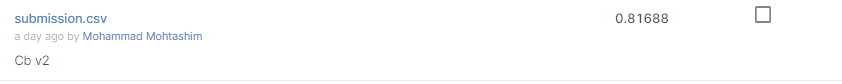

### 2-Xgboost

In [ ]:
best_parms_xg={'n_estimators': 4995,'learning_rate': 0.04,'subsample': 0.8,'colsample_bytree': 0.7934918764052317,
'max_depth': 3,'gamma':  2.143727883794004,'reg_alpha': 74,'reg_lambda': 89,'tree_method':'gpu_hist'}

In [ ]:
x_train, x_val, y_train, y_val = train_test_split(X, y, test_size=0.1, random_state=0)

In [ ]:
#xgboost_optimize()

In [ ]:
pred_tmp=k_fold(XGBClassifier,best_parms_xg)

In [ ]:
# average predictions over all folds
predictions_xgboost = np.mean(np.column_stack(pred_tmp),axis=1)

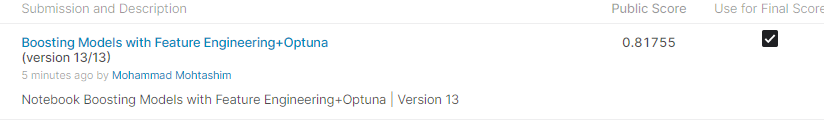

### 3-LightGBM

In [ ]:
best_parms_lgbm={'lambda_l1':2.217260840183882,
'lambda_l2': 0.00018113739596471642,
'num_leaves': 60,
'feature_fraction': 0.840321554033748,
'bagging_fraction':0.9762295967509231,
'bagging_freq': 4,
'min_child_samples': 27,
'device':'gpu'}

In [ ]:
x_train, x_val, y_train, y_val = train_test_split(X, y, test_size=0.1, random_state=0)

In [ ]:
#light_gbm_optimize()

In [ ]:
pred_tmp=k_fold(lgb.LGBMClassifier,best_parms_lgbm)

In [ ]:
# average predictions over all folds
predictions_lightgbm = np.mean(np.column_stack(pred_tmp),axis=1)

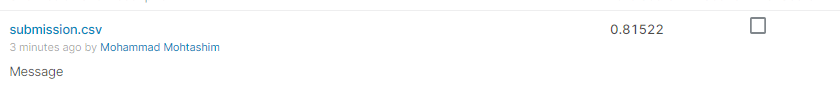

## Weightage Mean Submission

In [ ]:
final_prediction=(0.20*predictions_lightgbm)+(0.5*predictions_xgboost)+(0.30*predictions_catboost)

In [ ]:
submission=pd.DataFrame({
    "id":test["id"],
    "claim":final_prediction
    
})

In [ ]:
submission.to_csv("submission.csv",index=False)